In [154]:
import pandas as pd
import sys  
sys.path.insert(0, '../scripts')
import utilities
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
import numpy as np
import loading_data
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn import tree
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler



In [82]:
# load data
df = loading_data.load_csv('../Data/AdSmartABdata.csv')

/home/dibora/Testing-A-B/ab_testing/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  


### Split data by browser and platform_os, and version each split as a new version of the data in dvc.


In [83]:
# df_browser = df.groupby("browser")
# df_os = df.groupby("platform_os")

## Machine Learning for A/B Testing
Using Machine Learning for A/B Testing allows to consider different features when doing our analysis.

In [84]:
# transforming categorical to numerical
encoder = preprocessing.LabelEncoder() 

# Encode all columns. 
df['experiment']= encoder.fit_transform(df['experiment'])
df['date']= encoder.fit_transform(df['date'])
df['hour']= encoder.fit_transform(df['hour'])
df['device_make']= encoder.fit_transform(df['device_make'])
df['browser']= encoder.fit_transform(df['browser'])
df

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,1,7,8,46,6,2,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,1,4,10,46,6,2,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,1,2,2,29,6,3,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,0,0,15,137,6,6,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,0,0,15,46,6,2,0,0
...,...,...,...,...,...,...,...,...,...
8072,ffea24ec-cec1-43fb-b1d1-8f93828c2be2,1,2,7,46,6,2,0,0
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,0,0,15,46,6,2,0,0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,0,1,9,46,6,2,0,0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,1,2,15,130,6,14,0,0


In [162]:
# I don't know if we should keep the no responses or not
df_response = df[(df["yes"] == 0) ^ (df["no"] == 0)]
data = df_response.drop(["auction_id","no"], axis=1)
data_ml = data.rename(columns={"yes":"response"})
data_ml

,experiment,date,hour,device_make,platform_os,browser,response
2,1,2,2,29,6,3,0
16,1,1,16,46,6,2,1
20,1,3,8,46,6,2,0
23,0,5,4,114,6,6,1
27,0,0,15,46,6,2,0
...,...,...,...,...,...,...,...
8059,1,2,21,46,6,2,1
8063,1,1,1,46,6,2,1
8064,0,6,7,46,6,2,0
8069,0,7,16,46,6,2,0


In [163]:
# Split the data into 70% training, 20% validation, and 10% test sets. 
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data_ml))
scaled_data

,0,1,2,3,4,5,6
0,1.00,0.29,0.09,0.10,1.00,0.15,0.00
1,1.00,0.14,0.70,0.16,1.00,0.08,1.00
2,1.00,0.43,0.35,0.16,1.00,0.08,0.00
3,0.00,0.71,0.17,0.42,1.00,0.38,1.00
4,0.00,0.00,0.65,0.16,1.00,0.08,0.00
...,...,...,...,...,...,...,...
1238,1.00,0.29,0.91,0.16,1.00,0.08,1.00
1239,1.00,0.14,0.04,0.16,1.00,0.08,1.00
1240,0.00,0.86,0.30,0.16,1.00,0.08,0.00
1241,0.00,1.00,0.70,0.16,1.00,0.08,0.00


In [164]:
# partition data to features and target
X = np.array(scaled_data.iloc[:,:-1])
y = np.array(scaled_data.iloc[:,-1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.1, random_state=42)

In [165]:
# defining our models
clf_logistic = LogisticRegression(random_state=4)
clf_descions = tree.DecisionTreeClassifier()
clf_xgboost = XGBClassifier()

### KFold training of Logistic regression model, Decision trees and XGBoost
Kfold technique is usually used for comparing and selecting a model for a given task, so we will use kfold to compare all 3 models for A/B testing.

In [166]:
# using crosval score to evaluate and compare models

logistic_scores = []
decision_scores = []
xgboost_scores = []
kfold = KFold(n_splits=5, random_state=42, shuffle=True)
for train_index, test_index in kfold.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    clf_logistic.fit(X_train, y_train)
    clf_descions.fit(X_train,y_train)
    clf_xgboost.fit(X_train, y_train)

    logistic_scores.append(clf_logistic.score(X_test, y_test))
    decision_scores.append(clf_descions.score(X_test,y_test))
    xgboost_scores.append(clf_xgboost.score(X_test,y_test))
    # scores_logistic = cross_val_score(clf_logistic, X_test, y_test,
    #                      scoring="neg_mean_squared_error",
    #                      cv=5, n_jobs=1)
    # scores_trees = cross_val_score(clf_descions, X_test, y_test,
    #                      scoring="neg_mean_squared_error",
    #                      cv=5, n_jobs=1)
    # scores_xgboost = cross_val_score(clf_xgboost, X_test, y_test,
    #                      scoring="neg_mean_squared_error",
    #                      cv=5, n_jobs=1)

    # rmse_logistic = np.sqrt(-scores_logistic)
    # rmse_trees = np.sqrt(-scores_trees)
    # rmse_xgboost = np.sqrt(-scores_xgboost)

mean_score_logistic = np.array(logistic_scores).mean()
mean_score_trees = np.array(decision_scores).mean()
mean_score_xgboost = np.array(xgboost_scores).mean()
# mean_score_logistic =np.mean(rmse_logistic)
# mean_score_trees = np.mean(rmse_trees)
# mean_score_xgboost = np.mean(rmse_xgboost)

print("The mean score attained from logistic regression is ",mean_score_logistic)
print("The mean score attained from decision trees is ",mean_score_trees)
print("The mean score attained from Xgboost is ",mean_score_xgboost)

# print("The mean score attained from logistic regression is ",mean_score_logistic)
# print("The mean score attained from decision trees is ",mean_score_trees)
# print("The mean score attained from Xgboost is ",mean_score_xgboost)

/home/dibora/Testing-A-B/ab_testing/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/dibora/Testing-A-B/ab_testing/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:19:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:19:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/dibora/Testing-A-B/ab_testing/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/dibora/Testing-A-B/ab_testing/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/dibora/Testing-A-B/ab_testing/lib/python3.7/

[15:19:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:19:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:19:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The mean score attained from logistic regression is  0.5350239668350822
The mean score attained from decision trees is  0.5285885477393444
The mean score attained from Xgboost is  0.5518720041456147


#### Interpretations 

In [167]:
#  Train a machine learning model using 5-fold cross validation using the following 3 different algorithms:
# Logistic Regression 
# Decision Trees
# XGBoost


In [168]:
# Define the appropriate loss function  for the model using the validation data. 


In [169]:
decision_clf_trained = clf_descions.fit(X_train,y_train)
logistic_clf_trained = clf_logistic.fit(X_train,y_train)
xgboost_clf_trained = clf_xgboost.fit(X_train,y_train)

[15:19:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/dibora/Testing-A-B/ab_testing/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [170]:
# Compute feature importance - what’s driving the model? Which parameters are important predictors for the different ML models? What contributes to the goal of gaining more “Yes” results?
# Which data features are relevant to predicting the target variable?



### Feature importance scores 
Feature importance scores are useful to under the data and model better. Feature importance help to narrow features that have the most effect.

In [171]:
def plot_feature_importance(features,importance,model):
    # plot feature importance
    feature_df = pd.DataFrame({"features":features,"feature_importance": importance })
    plt.figure(figsize=(20, 7))
    sn.catplot(data=feature_df,x="features",y="feature_importance",kind="bar")
    plt.title("Feature importance plot for "+model)
    plt.show()
    print(feature_df)

<Figure size 1440x504 with 0 Axes>

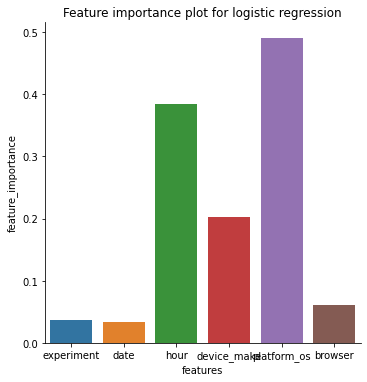

      features  feature_importance
0   experiment                0.04
1         date                0.03
2         hour                0.38
3  device_make                0.20
4  platform_os                0.49
5      browser                0.06


In [172]:
# get importance of logistic regression by looking at their weight
features = ["experiment","date","hour","device_make","platform_os","browser"]
# clf_logistic.fit(X_valid,y_valid)
importance = logistic_clf_trained.coef_[0]

# plot feature importance
plot_feature_importance(features,importance,model="logistic regression")

<Figure size 1440x504 with 0 Axes>

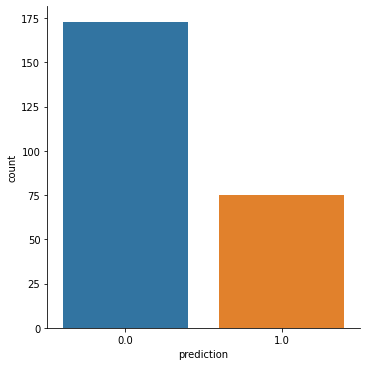

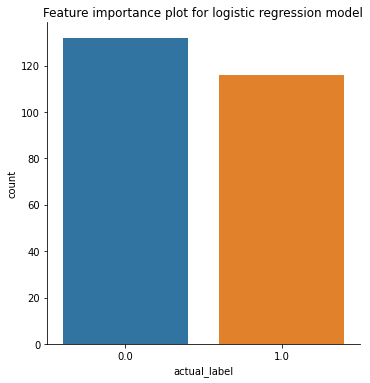

In [173]:
y_pred = clf_descions.predict(X_test)
logistic_df = pd.DataFrame({"prediction":y_pred,"actual_label":y_test})
plt.figure(figsize=(20, 7))
sn.catplot(data=logistic_df,x="prediction",kind="count")
sn.catplot(data=logistic_df,x="actual_label",kind="count")
plt.title("Feature importance plot for logistic regression model")
plt.show()

### Feature importance for Decision Trees
Decision tree algorithms offer importance of features by using CART or entropy

<Figure size 1440x504 with 0 Axes>

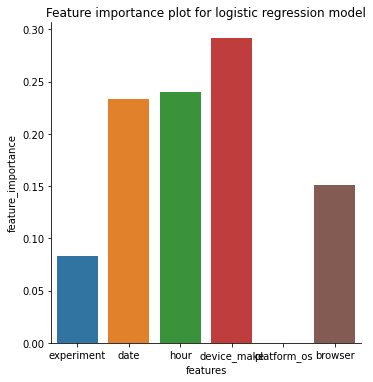

      features  feature_importance
0   experiment                0.08
1         date                0.23
2         hour                0.24
3  device_make                0.29
4  platform_os                0.00
5      browser                0.15


In [123]:
clf_descions.fit(X_valid,y_valid)
# get importance
importance = clf_descions.feature_importances_

# plot feature importance
plot_feature_importance(features,importance)

<Figure size 1440x504 with 0 Axes>

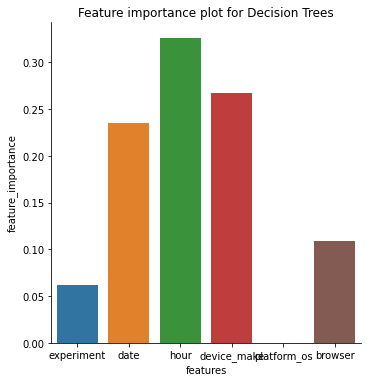

      features  feature_importance
0   experiment                0.06
1         date                0.23
2         hour                0.33
3  device_make                0.27
4  platform_os                0.00
5      browser                0.11


In [146]:
clf_descions.fit(X_train,y_train)
# get importance
importance = clf_descions.feature_importances_
# plot feature importance
plot_feature_importance(features,importance,model="Decision Trees")

### Feature importance for XGboost model

<Figure size 1440x504 with 0 Axes>

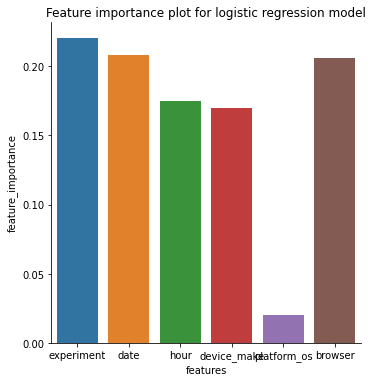

      features  feature_importance
0   experiment                0.22
1         date                0.21
2         hour                0.17
3  device_make                0.17
4  platform_os                0.02
5      browser                0.21


In [139]:
clf_xgboost.fit(X_train,y_train)
# get importance
importance = clf_xgboost.feature_importances_
# plot feature importance
plot_feature_importance(features,importance,model="xgboost")

In [ ]:
# For each of the ML algorithms above, find the best model by tuning their hyperparameters and each time adding the tried models in MLFlow.
# Prepare a Dockerfile for your project so that your model can be deployed in a docker container.